# Visualize trained agent

In [ ]:
!pip install pyro-ppl &> /dev/null

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
cwd = "drive/MyDrive/HFES_2023_Ran_paper/random_effect_active_inference"
sys.path.append(cwd)

In [ ]:
import os
import glob
import json
import pickle
import math
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.mixture import GaussianMixture
from sklearn.decomposition import FactorAnalysis

import torch
from src.ebirl import EBIRL
from src.data import pad_collate

seed = 0

# set plotting style
strip_size = 12
label_size = 14
font_family = "times new roman"
mpl.rcParams["font.family"] = font_family
mpl.rcParams["axes.labelsize"] = label_size
mpl.rcParams["xtick.labelsize"] = strip_size
mpl.rcParams["ytick.labelsize"] = strip_size
mpl.rcParams["legend.title_fontsize"] = strip_size
mpl.rcParams["legend.fontsize"] = strip_size

In [ ]:
project_path = "drive/MyDrive/HFES_2023_Ran_paper"
data_path = os.path.join(project_path, "data")
exp_path = os.path.join(project_path, "exp")

In [ ]:
# load data
with open(os.path.join(data_path, "data.p"), "rb") as f:
    dataset = pickle.load(f)

# parse data
data = [
    {
        k: torch.from_numpy(v).to(torch.float32) 
        for k, v in d.items() if k not in ["drive_id", "t"]
    } for d in dataset
]
data, mask = pad_collate(data)

# data sampling time factor
t_factor = 0.2

# process data
nan_mask = mask.clone()
nan_mask[mask == 0] = torch.nan
obs_np = (nan_mask.unsqueeze(-1) * data["obs"]).numpy()

obs_mean = np.nanmean(obs_np, axis=(0, 1))
obs_std = np.nanstd(obs_np, axis=(0, 1))

obs_mean_torch = torch.from_numpy(obs_mean).to(torch.float32)
obs_std_torch = torch.from_numpy(obs_std).to(torch.float32)

obs = (data["obs"] - obs_mean) / obs_std
act = data["act"].long()

data = (obs, act, mask)

batch_size = obs.shape[1]
act_dim = len(torch.unique(act))
obs_dim = obs.shape[-1]

print("data size", obs.shape, act.shape, mask.shape)
print("traj length", mask.sum(0).sort()[0].data.numpy())
print("mean traj length", mask.sum(0).sort()[0].data.numpy().mean())

data size torch.Size([128, 38, 2]) torch.Size([128, 38]) torch.Size([128, 38])
traj length [ 44.  45.  46.  48.  48.  48.  49.  50.  50.  50.  50.  51.  56.  56.
  58.  59.  68.  69.  72.  73.  73.  73.  74.  76.  78.  80.  80.  87.
  92.  96.  99. 103. 104. 105. 110. 113. 126. 128.]
mean traj length 73.3421


In [ ]:
# load agent
exp_name = "02-16-2023 15-47-03"

with open(os.path.join(exp_path, exp_name, "args.json"), "rb") as f:
    arglist = json.load(f)

model = EBIRL(
    arglist["state_dim"], act_dim, obs_dim, arglist["horizon"], 
    prior_cov=arglist["prior_cov"], bc_penalty=arglist["bc_penalty"], 
    obs_penalty=arglist["obs_penalty"], kl_penalty=arglist["kl_penalty"]
)
model.init_q(batch_size, freeze_prior=False)

state_dict = torch.load(os.path.join(exp_path, exp_name, "model.pt"))
model.load_state_dict(state_dict["model_state_dict"], strict=False)

agent = model.agent
agent.eval()

ActiveInference(state_dim=2, act_dim=2, obs_idm=2, horizon=30)

In [ ]:
# load simulation results
df_sim = pd.read_csv(os.path.join(exp_path, exp_name, "simulation.csv"))

## Get posterior and predictions

In [ ]:
# predict
with torch.no_grad():
    q_dist = model.get_q_dist()
    q_mean = q_dist.mean
    
    pi, b, logp_o = agent.forward(obs, act, q_mean)

# mask sequences
obs_mask = obs * nan_mask.unsqueeze(-1)
act_mask = act * nan_mask
pi_mask = pi * nan_mask.unsqueeze(-1)
b_mask = b * nan_mask.unsqueeze(-1)

print("pred size", pi.shape, b.shape, logp_o.shape)

pred size torch.Size([128, 38, 2]) torch.Size([128, 38, 2]) torch.Size([128, 38])


## Visualize trajectories

In [ ]:
def plot_trajectory(t, obs, act, pi, b, ax, obs_labels):
    ax[0].plot(t, obs[:, 0], '-o')
    ax[1].plot(t, obs[:, 1], '-o')
    ax[2].plot(t, act, "-o", label="Data")
    ax[2].plot(t, pi, "-o", label="Model")
    ax[3].plot(t, b[:, 0], "-go")
    ax[3].plot(t, b[:, 1], "-ro")

    ax[2].legend()

    ax[0].set_ylabel(obs_labels[0])
    ax[1].set_ylabel(obs_labels[1])
    ax[2].set_ylabel("Disengage")
    ax[3].set_ylabel("Belief")

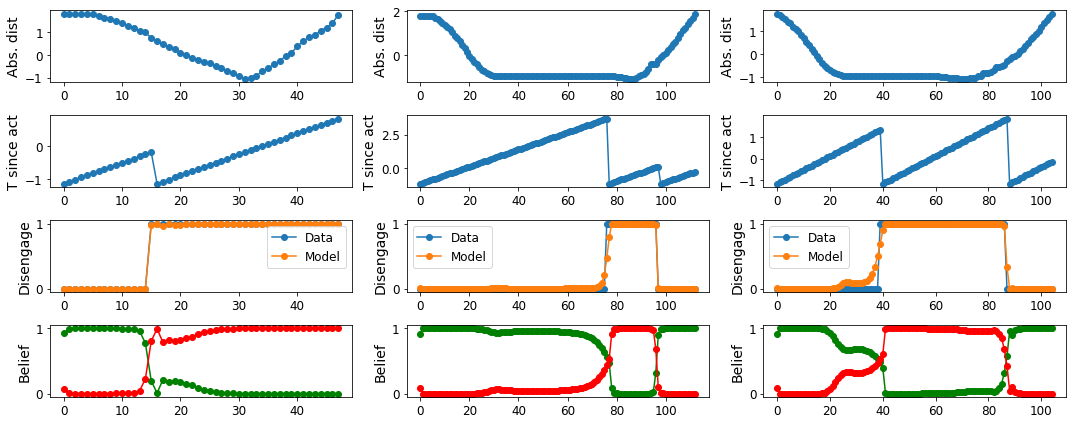

In [ ]:
obs_labels = ["Abs. dist", "T since act"]
t = torch.arange(len(obs))
fig, ax = plt.subplots(4, 3, figsize=(15, 6))

eps_id = 0
plot_trajectory(
    t, 
    obs_mask[:, eps_id], 
    1 - act_mask[:, eps_id], 
    pi_mask[:, eps_id, 0], 
    b_mask[:, eps_id],
    ax[:, 0],
    obs_labels
)

eps_id = 1
plot_trajectory(
    t,
    obs_mask[:, eps_id], 
    1 - act_mask[:, eps_id], 
    pi_mask[:, eps_id, 0], 
    b_mask[:, eps_id],
    ax[:, 1],
    obs_labels
)

eps_id = 2
plot_trajectory(
    t,
    obs_mask[:, eps_id], 
    1 - act_mask[:, eps_id], 
    pi_mask[:, eps_id, 0], 
    b_mask[:, eps_id],
    ax[:, 2],
    obs_labels
)

plt.tight_layout()
plt.show()

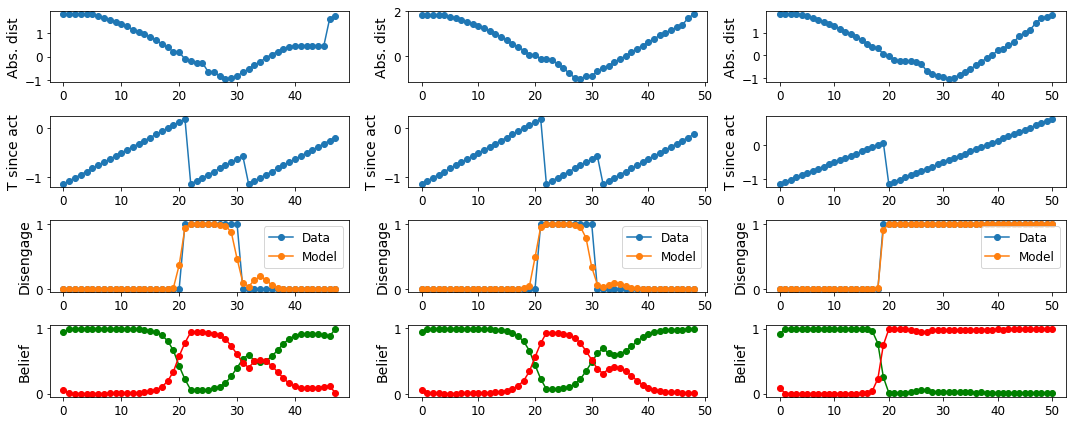

In [ ]:
fig, ax = plt.subplots(4, 3, figsize=(15, 6))

eps_id = 3
plot_trajectory(
    t,
    obs_mask[:, eps_id], 
    1 - act_mask[:, eps_id], 
    pi_mask[:, eps_id, 0], 
    b_mask[:, eps_id],
    ax[:, 0],
    obs_labels
)

eps_id = 4
plot_trajectory(
    t,
    obs_mask[:, eps_id], 
    1 - act_mask[:, eps_id], 
    pi_mask[:, eps_id, 0], 
    b_mask[:, eps_id],
    ax[:, 1],
    obs_labels
)

eps_id = 5
plot_trajectory(
    t,
    obs_mask[:, eps_id], 
    1 - act_mask[:, eps_id], 
    pi_mask[:, eps_id, 0], 
    b_mask[:, eps_id],
    ax[:, 2],
    obs_labels
)

plt.tight_layout()
plt.show()

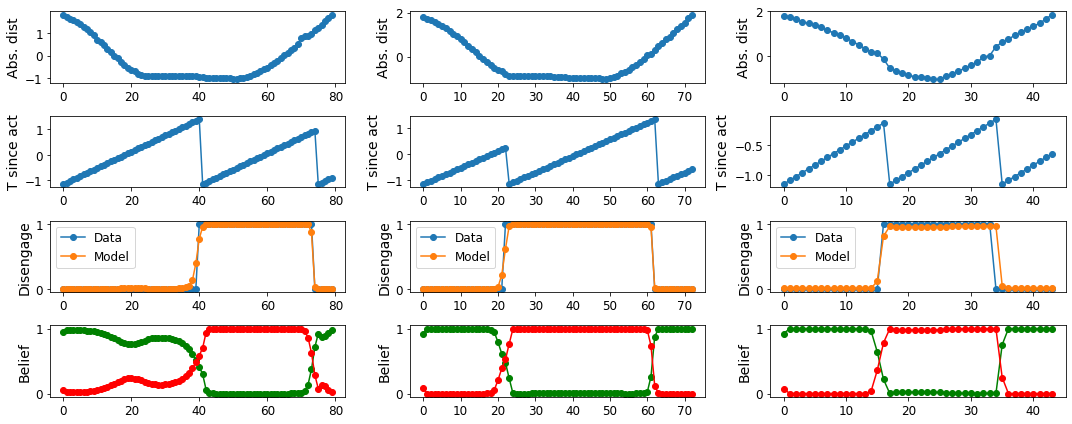

In [ ]:
fig, ax = plt.subplots(4, 3, figsize=(15, 6))

eps_id = 6
plot_trajectory(
    t,
    obs_mask[:, eps_id], 
    1 - act_mask[:, eps_id], 
    pi_mask[:, eps_id, 0], 
    b_mask[:, eps_id],
    ax[:, 0],
    obs_labels
)

eps_id = 7
plot_trajectory(
    t,
    obs_mask[:, eps_id], 
    1 - act_mask[:, eps_id], 
    pi_mask[:, eps_id, 0], 
    b_mask[:, eps_id],
    ax[:, 1],
    obs_labels
)

eps_id = 8
plot_trajectory(
    t,
    obs_mask[:, eps_id], 
    1 - act_mask[:, eps_id], 
    pi_mask[:, eps_id, 0], 
    b_mask[:, eps_id],
    ax[:, 2],
    obs_labels
)

plt.tight_layout()
plt.show()

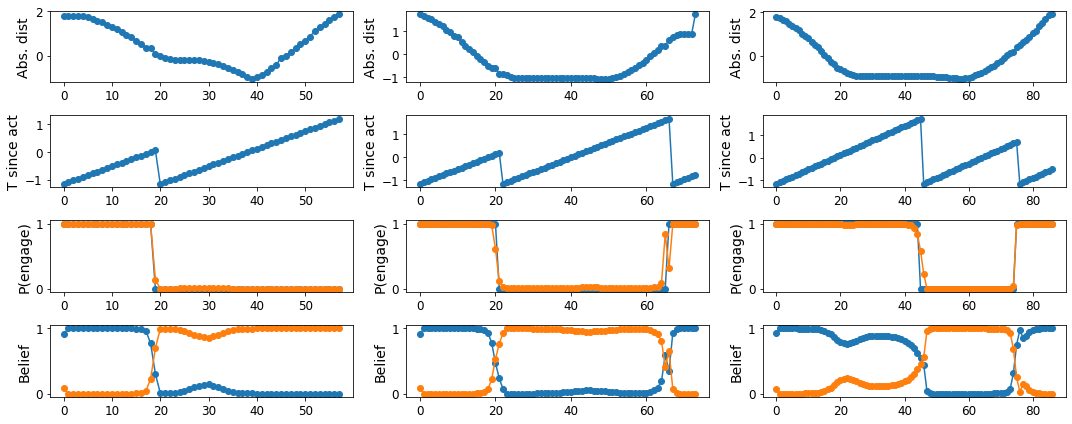

In [ ]:
fig, ax = plt.subplots(4, 3, figsize=(15, 6))

eps_id = 9
plot_trajectory(
    t,
    obs_mask[:, eps_id], 
    1 - act_mask[:, eps_id], 
    pi_mask[:, eps_id, 0], 
    b_mask[:, eps_id],
    ax[:, 0],
    obs_labels
)

eps_id = 10
plot_trajectory(
    t,
    obs_mask[:, eps_id], 
    1 - act_mask[:, eps_id], 
    pi_mask[:, eps_id, 0], 
    b_mask[:, eps_id],
    ax[:, 1],
    obs_labels
)

eps_id = 11
plot_trajectory(
    t,
    obs_mask[:, eps_id], 
    1 - act_mask[:, eps_id], 
    pi_mask[:, eps_id, 0], 
    b_mask[:, eps_id],
    ax[:, 2],
    obs_labels
)

plt.tight_layout()
plt.show()

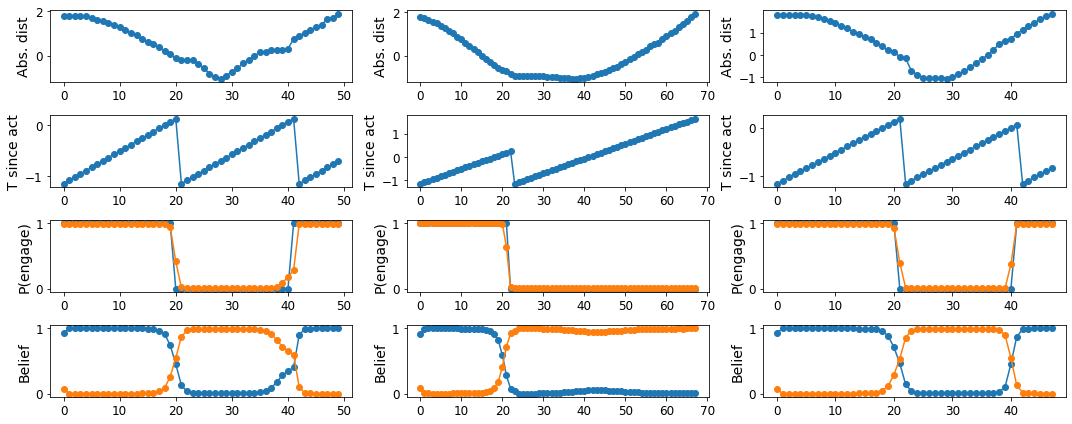

In [ ]:
fig, ax = plt.subplots(4, 3, figsize=(15, 6))

eps_id = 12
plot_trajectory(
    t,
    obs_mask[:, eps_id], 
    1 - act_mask[:, eps_id], 
    pi_mask[:, eps_id, 0], 
    b_mask[:, eps_id],
    ax[:, 0],
    obs_labels
)

eps_id = 13
plot_trajectory(
    t,
    obs_mask[:, eps_id], 
    1 - act_mask[:, eps_id], 
    pi_mask[:, eps_id, 0], 
    b_mask[:, eps_id],
    ax[:, 1],
    obs_labels
)

eps_id = 14
plot_trajectory(
    t,
    obs_mask[:, eps_id], 
    1 - act_mask[:, eps_id], 
    pi_mask[:, eps_id, 0], 
    b_mask[:, eps_id],
    ax[:, 2],
    obs_labels
)

plt.tight_layout()
plt.show()

## Analyze agent parameters

In [ ]:
def get_agent_parameters(agent, q, obs_mean, obs_std):
    with torch.no_grad():
        A, B, C, D, tau= agent.transform_params(q)

    A_mean = A.mean * obs_std + obs_mean
    A_std = A.variance**0.5 * obs_std
    return A_mean.data, A_std.data, B.data, C.data, D.data, tau.data

A_mean, A_std, B, C, D, tau = get_agent_parameters(
    agent, q_mean, obs_mean_torch.view(1, -1), obs_std_torch.view(1, -1)
)

In [ ]:
eps_id = 0
print("A_mean", A_mean[eps_id].numpy().round(2))
print("A_std", A_std[eps_id].numpy().round(2))
print("B", B[eps_id].numpy().round(2))
print("C", C[eps_id].numpy().round(2))
print("D", D[eps_id].numpy().round(2))
print("tau", tau[eps_id].numpy().round(2))

A_mean [[148.92   5.55]
 [ 52.6   10.39]]
A_std [[38.58  2.85]
 [32.76 12.51]]
B [[[0.15 0.85]
  [0.45 0.55]]

 [[0.97 0.03]
  [0.04 0.96]]]
C [[1. 0.]]
D [0.92 0.08]
tau [35.34]


In [ ]:
eps_id = 1
print("A_mean", A_mean[eps_id].numpy().round(2))
print("A_std", A_std[eps_id].numpy().round(2))
print("B", B[eps_id].numpy().round(2))
print("C", C[eps_id].numpy().round(2))
print("D", D[eps_id].numpy().round(2))
print("tau", tau[eps_id].numpy().round(2))

A_mean [[ 15.94  44.28]
 [  1.36 -11.76]]
A_std [[ 43.9   17.51]
 [ 13.79 120.21]]
B [[[1.   0.  ]
  [0.   1.  ]]

 [[0.92 0.08]
  [0.1  0.9 ]]]
C [[0. 1.]]
D [0.92 0.08]
tau [44.76]


In [ ]:
eps_id = 2
print("A_mean", A_mean[eps_id].numpy().round(2))
print("A_std", A_std[eps_id].numpy().round(2))
print("B", B[eps_id].numpy().round(2))
print("C", C[eps_id].numpy().round(2))
print("D", D[eps_id].numpy().round(2))
print("tau", tau[eps_id].numpy().round(2))

A_mean [[51.19 28.12]
 [ 8.9   2.05]]
A_std [[39.35  9.26]
 [11.51 63.57]]
B [[[0.99 0.01]
  [0.   1.  ]]

 [[0.81 0.19]
  [0.23 0.77]]]
C [[0. 1.]]
D [0.92 0.08]
tau [38.32]


## Visualize posterior structure

In [ ]:
# pack posteriors
df_q = pd.DataFrame(q_mean.data.numpy())

torch.manual_seed(seed)

num_samples = 300
with torch.no_grad():
    q_sample = q_dist.sample((num_samples, )).flatten(0, 1)

df_q_sample = pd.DataFrame(q_sample.data.numpy())

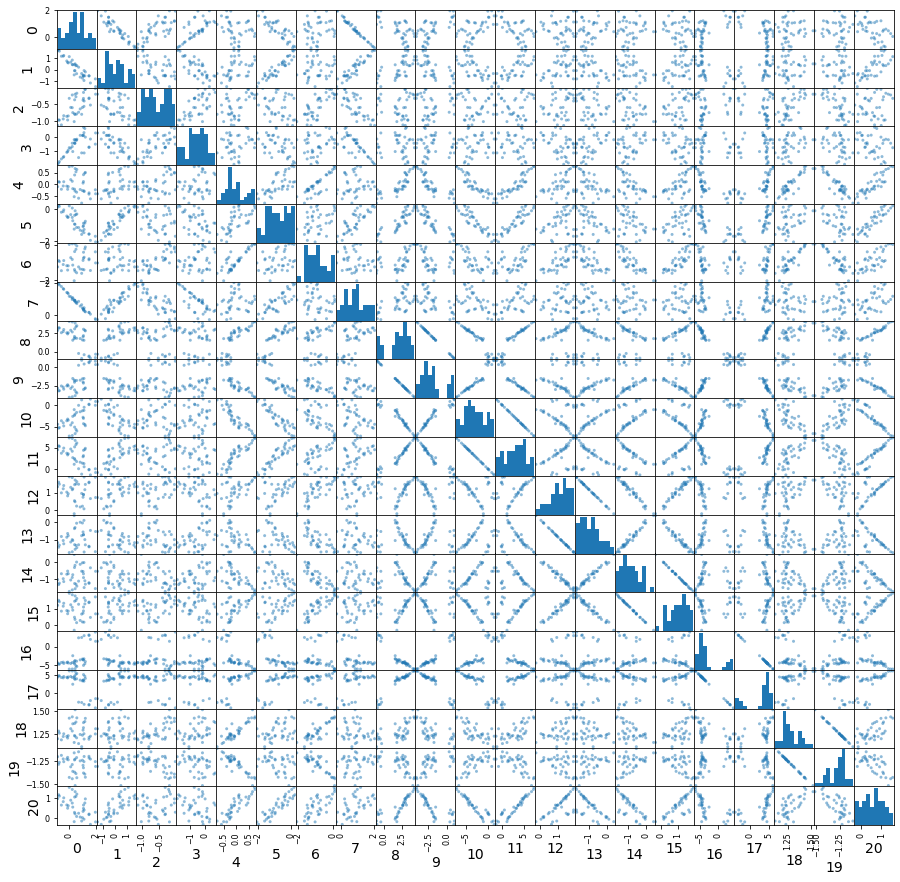

In [ ]:
# visualize map estimates
pd.plotting.scatter_matrix(
    df_q, figsize=(15, 15)
)

plt.show()

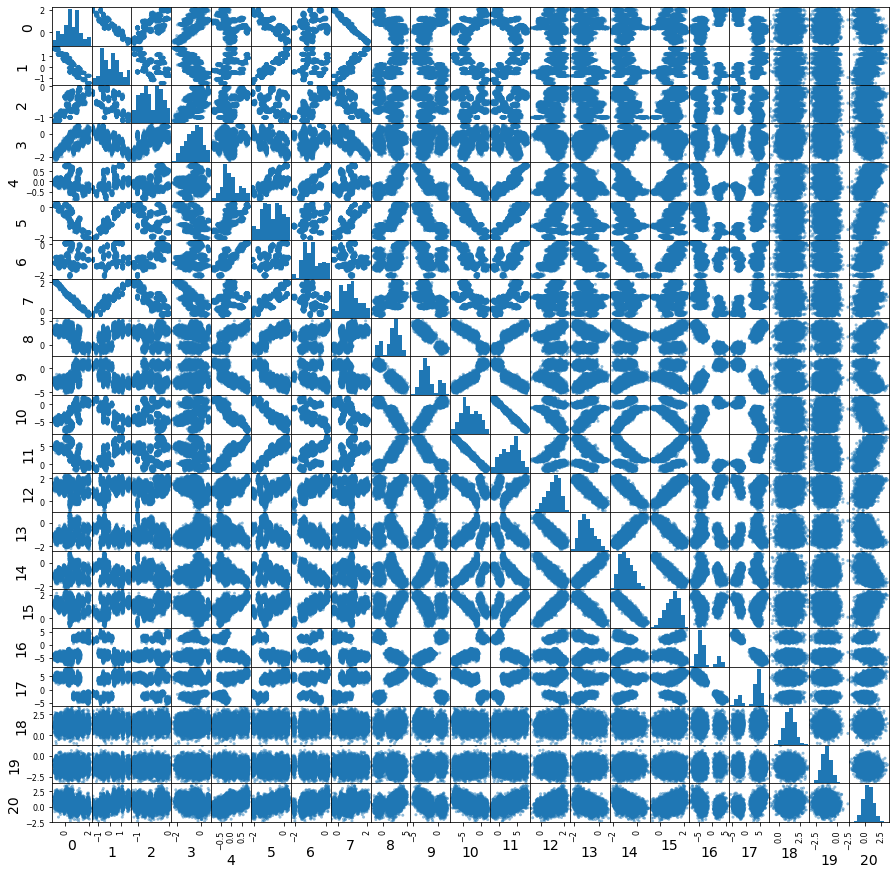

In [ ]:
# visualize full posterior
pd.plotting.scatter_matrix(
    df_q_sample, figsize=(15, 15)
)

plt.show()

## Factor analysis

In [ ]:
def fit_gmm_models(df, num_components):
    gmm_models = []
    gmm_scores = []
    gmm_bics = []
    for n in num_components[:]:
        gmm = GaussianMixture(n_components=n, covariance_type="full").fit(df)

        gmm_models.append(gmm)
        gmm_scores.append(gmm.score(df))
        gmm_bics.append(-gmm.bic(df))
    return gmm_models, gmm_scores, gmm_bics
    
def fit_factor_models(df, num_components, rotation="varimax"):
    fa_models = []
    fa_scores = []
    fa_bics = []
    for n in num_components[:]:
        fa = FactorAnalysis(n_components=n, rotation=rotation).fit(df)
        score = fa.score(df)
        bic = score * len(df) - math.log(len(df)) * (
            np.prod(list(fa.mean_.shape)) + 
            np.prod(list(fa.components_.shape)) + 
            np.prod(list(fa.noise_variance_.shape))
        )
        
        fa_models.append(fa)
        fa_scores.append(score)
        fa_bics.append(bic)
    return fa_models, fa_scores, fa_bics

In [ ]:
# fit factor models
np.random.seed(seed)

num_components = np.arange(2, 10)

fa_models, fa_scores, fa_bics = fit_factor_models(df_q_sample, num_components, rotation="varimax")

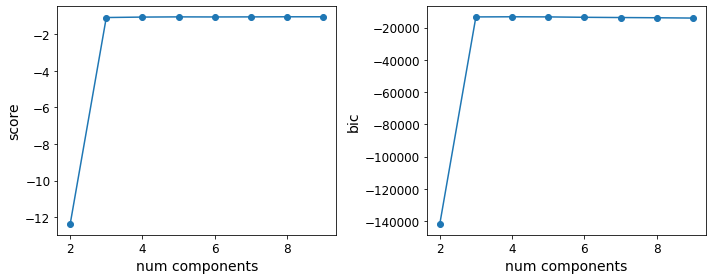

In [ ]:
# plot model selection
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(num_components, fa_scores, "-o")
ax[0].set_xlabel("num components")
ax[0].set_ylabel("score")

ax[1].plot(num_components, fa_bics, "-o")
ax[1].set_xlabel("num components")
ax[1].set_ylabel("bic")

plt.tight_layout()
plt.show()

In [ ]:
# compute latent factors
pred = fa_models[1].transform(df_q_sample)

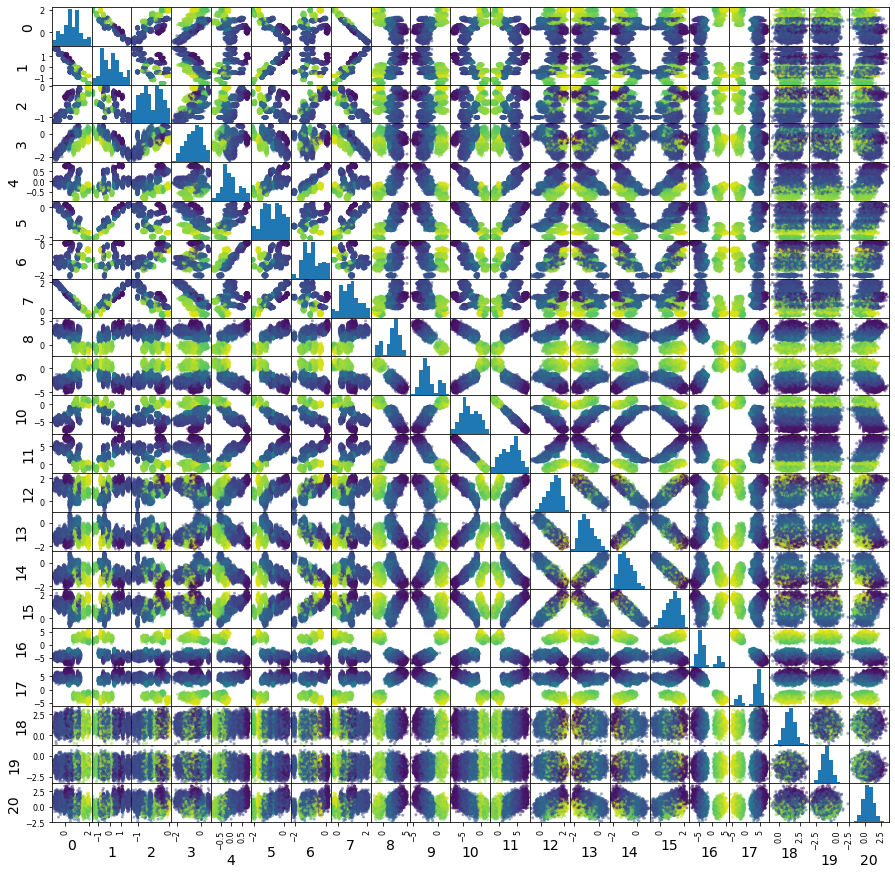

In [ ]:
pd.plotting.scatter_matrix(
    df_q_sample, figsize=(15, 15), c=pred[:, 0]
)

plt.show()

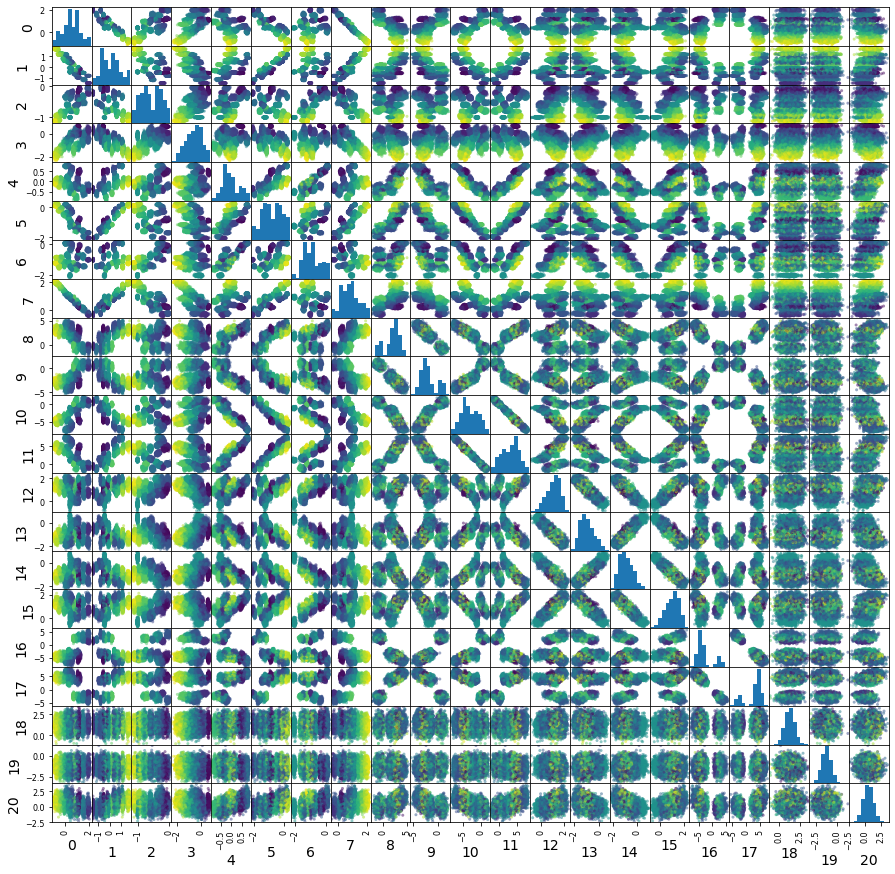

In [ ]:
pd.plotting.scatter_matrix(
    df_q_sample, figsize=(15, 15), c=pred[:, 1]
)

plt.show()

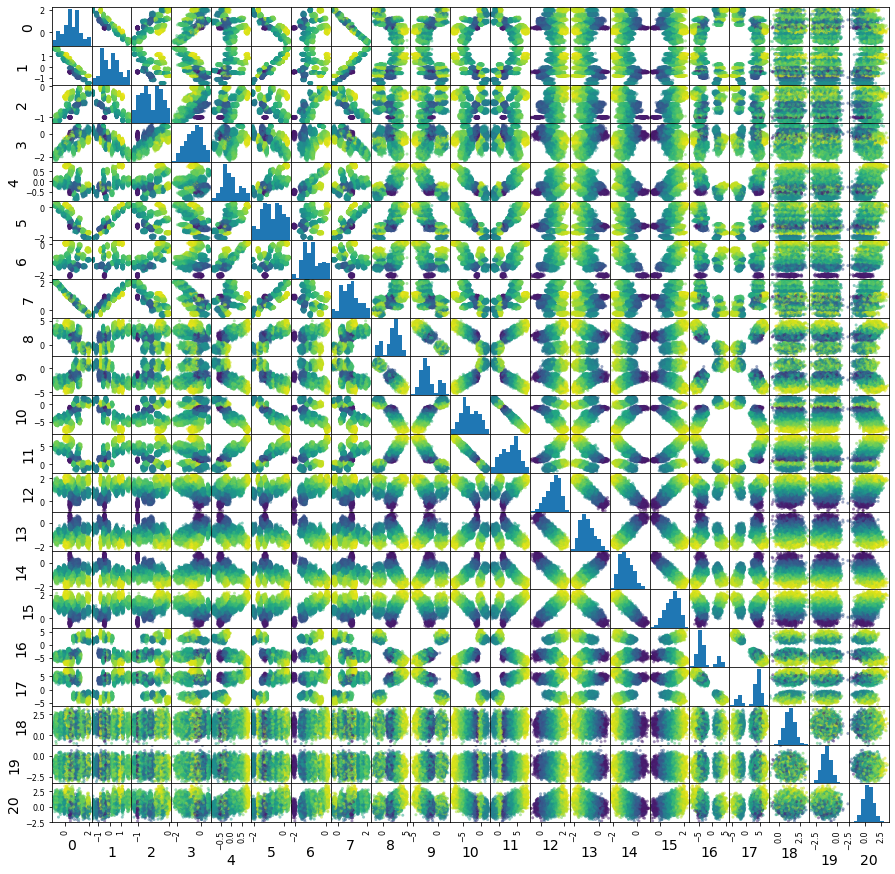

In [ ]:
pd.plotting.scatter_matrix(
    df_q_sample, figsize=(15, 15), c=pred[:, 2]
)

plt.show()

In [ ]:
# make parameter labels
A_mean_labels = ["$\mu_{0d}$", "$\mu_{0l}$", "$\mu_{1d}$", "$\mu_{1l}$"]
A_std_labels = ["$\sigma_{0d}$", "$\sigma_{0l}$", "$\sigma_{1d}$", "$\sigma_{1l}$"]
B_labels = ["$B_{%d%d}^{%d}$"%(i, j, k) for k in range(agent.act_dim) for i in range(agent.state_dim) for j in range(agent.state_dim)]
C_labels = ["$C_{%d}$"%(i) for i in range(agent.state_dim)]
D_labels = ["$D_{%d}$"%(i) for i in range(agent.state_dim)]
tau_labels = [r"$\tau$"]

B_labels_eff = ["$B_{00}^{0}$", "$B_{11}^{0}$", "$B_{00}^{1}$", "$B_{11}^{1}$"]
C_labels_eff = ["$C_{0}$"]
D_labels_eff = ["$D_{0}$"]

labels = A_mean_labels + A_std_labels + B_labels + C_labels + D_labels + tau_labels
labels_eff = A_mean_labels + A_std_labels + B_labels_eff + C_labels_eff + D_labels_eff + tau_labels

In [ ]:
# pack factor analysis results
weights = fa_models[1].components_
means = fa_models[1].mean_
vars = fa_models[1].noise_variance_

# compuate mean values from agent
with torch.no_grad():
    A_mean_fa, A_std_fa, B_fa, C_fa, D_fa, tau_fa = get_agent_parameters(
        agent, torch.from_numpy(means).view(1, -1).to(torch.float32), obs_mean, obs_std
    )

transformed_means = torch.cat([
    A_mean_fa.flatten(), A_std_fa.flatten(), B_fa.flatten(), 
    C_fa.flatten(), D_fa.flatten(), tau_fa.flatten() * t_factor
], dim=-1).data.numpy()

df_weights = pd.DataFrame(weights, columns=labels, index=np.arange(len(weights)) + 1)
df_means = pd.DataFrame(means.reshape(1, -1), columns=labels, index=["Means"])
df_transformed_means = pd.DataFrame(
    transformed_means.reshape(1, -1), columns=labels, index=["Means"]
)
df_vars = pd.DataFrame(vars.reshape(1, -1), columns=labels, index=["Variance"])

df_weights_eff = df_weights[labels_eff]
df_transformed_means_eff = df_transformed_means[labels_eff]
df_vars_eff = df_vars[labels_eff]

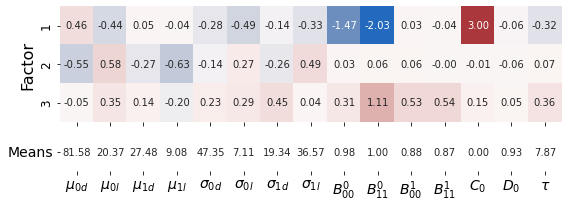

In [ ]:
# plot factor analysis results
vertical = False

if vertical:
    nrows = 1
    ncols = 2
    figsize=(5, 7)
    sharey=True
    sharex=False
    h_ratios = [1]
    w_ratios = [1, df_weights_eff.shape[0]]
else:
    nrows = 2
    ncols = 1
    figsize=(8, 3)
    sharey=False
    sharex=True
    w_ratios = [1]
    h_ratios = [df_weights_eff.shape[0], 1]

fig_loading, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, sharey=sharey, sharex=sharex, \
    gridspec_kw=dict(height_ratios=h_ratios, width_ratios=w_ratios)
)

if vertical:
    sns.heatmap(
        df_transformed_means_eff.T, fmt=".2f", annot=True, cbar=False, cmap="gray", 
        norm=mpl.colors.TwoSlopeNorm(vcenter=0, vmin=0-1e-5, vmax=0+1e-5), ax=ax[0]
    )
    sns.heatmap(
        df_weights_eff.T, fmt=".2f", annot=True, cbar=False, cmap="vlag", 
        norm=mpl.colors.TwoSlopeNorm(vcenter=0), ax=ax[1]
    )

    ax[0].set_yticklabels(ax[0].get_yticklabels(), rotation=0)
    ax[1].set_xlabel("Factor")
else:
    sns.heatmap(
        df_weights_eff, fmt=".2f", annot=True, cbar=False, cmap="vlag", 
        norm=mpl.colors.TwoSlopeNorm(vcenter=0), ax=ax[0]
    )
    sns.heatmap(
        df_transformed_means_eff, fmt=".2f", annot=True, cbar=False, cmap="gray", 
        norm=mpl.colors.TwoSlopeNorm(vcenter=0, vmin=0-1e-5, vmax=0+1e-5), ax=ax[1]
    )
    ax[0].set_ylabel("Factor", fontsize=16)
    ax[1].set_yticklabels(ax[1].get_yticklabels(), rotation=0, fontsize=14)
    ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=0, fontsize=14)

plt.tight_layout()
plt.show()

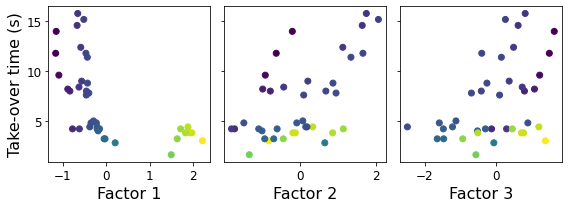

In [ ]:
# plot agent z and rt
z = fa_models[1].transform(df_q)

fig_rt, ax = plt.subplots(1, 3, figsize=(8, 3), sharey=True)

ax[0].scatter(z[:, 0], df_sim["rt_true"] * t_factor, c=z[:, 0])
ax[1].scatter(z[:, 1], df_sim["rt_true"] * t_factor, c=z[:, 0])
ax[2].scatter(z[:, 2], df_sim["rt_true"] * t_factor, c=z[:, 0])

ax[0].set_xlabel("Factor 1", fontsize=16)
ax[1].set_xlabel("Factor 2", fontsize=16)
ax[2].set_xlabel("Factor 3", fontsize=16)

ax[0].set_ylabel("Take-over time (s)", fontsize=16)

plt.tight_layout()
plt.show()

## Plot reaction time predictions vs data

In [ ]:
from scipy.stats import ks_2samp

In [ ]:
# predictive ks test
ks_2samp(df_sim["rt_true"], df_sim["rt_pred"], alternative="two-sided")

KstestResult(statistic=0.10526315789473684, pvalue=0.9866453783650283)

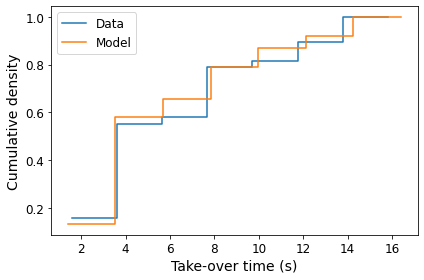

In [ ]:
cumulative = True
hist_type = "step"
stat = "density"

fig_fit, ax = plt.subplots(1, 1, figsize=(6, 4))
sns.histplot(
    df_sim["rt_true"] * t_factor, cumulative=cumulative, fill=False, 
    element=hist_type, stat=stat, label="Data",
ax=ax)
sns.histplot(
    df_sim["rt_pred"] * t_factor, cumulative=cumulative, fill=False, 
    element=hist_type, stat=stat, label="Model",
ax=ax)

ax.legend()
ax.set_xlabel("Take-over time (s)")
ax.set_ylabel("Cumulative density")

plt.tight_layout()
plt.show()

## Pretty plot trajectories

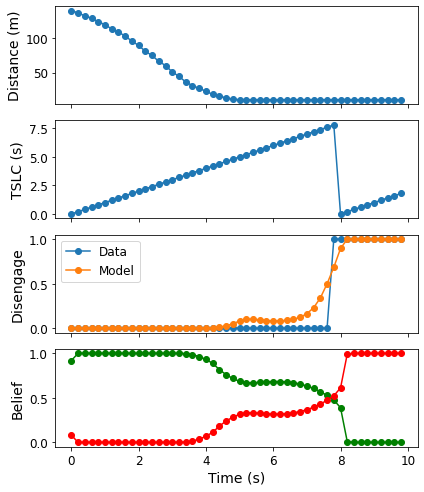

In [ ]:
obs_labels = ["Distance (m)", "TSLC (s)"]

t_max = min(50, len(obs))
t = torch.arange(t_max) * t_factor
obs_traj = obs_mask[:, eps_id] * obs_std + obs_mean
obs_traj[:, 1] *= t_factor

fig_traj, ax = plt.subplots(4, 1, figsize=(6, 7), sharex=True)
eps_id = 2
plot_trajectory(
    t,
    obs_traj[:t_max], 
    1 - act_mask[:t_max, eps_id], 
    pi_mask[:t_max, eps_id, 0], 
    b_mask[:t_max, eps_id],
    ax,
    obs_labels
)

ax[-1].set_xlabel("Time (s)")
plt.tight_layout()
plt.show()

In [ ]:
# get agent z
z[2]

array([-0.39922642,  0.95046683, -0.68590085])

## Save fig

In [ ]:
# save fig
fig_path = os.path.join(exp_path, exp_name, "fig")
if not os.path.exists(fig_path):
    os.mkdir(fig_path)

fig_loading.savefig(os.path.join(fig_path, "factor_loading.png"), dpi=100)
fig_rt.savefig(os.path.join(fig_path, "rt.png"), dpi=100)
fig_fit.savefig(os.path.join(fig_path, "fit_check.png"), dpi=100)
fig_traj.savefig(os.path.join(fig_path, "traj.png"), dpi=100)

## Save results

In [ ]:
# pack trajectory data
traj_data = []
for eps_id in range(batch_size):
    traj_len = mask[:, eps_id].sum().long().data.item()
    obs_traj = obs_mask[:traj_len, eps_id] * obs_std + obs_mean
    act_traj = act_mask[:traj_len, eps_id].view(-1, 1)
    pi_traj = pi_mask[:traj_len, eps_id]
    b_traj = b_mask[:traj_len, eps_id]

    drive_id = dataset[eps_id]["drive_id"]
    
    df_traj = pd.DataFrame(
        torch.cat([obs_traj, act_traj, pi_traj, b_traj], dim=-1).data.numpy(),
        columns=["euc_dist", "time_since_act", "act", "pi_0", "pi_1", "b_0", "b_1"]
    )
    df_traj = df_traj.assign(drive_id=drive_id)
    
    traj_data.append(df_traj)

df_all_traj = pd.concat(traj_data, axis=0)

In [ ]:
# pack factors analysis results
df_z = pd.DataFrame(z, columns=["Factor 1", "Factor 2", "Factor 3"])
df_z = df_z.assign(drive_id=df_sim["drive_id"])
df_fa = pd.concat([df_weights, df_means, df_transformed_means, df_vars], axis=0)

In [ ]:
# save all results
df_all_traj.to_csv(os.path.join(exp_path, exp_name, "trajectories.csv"), index=False)
df_z.to_csv(os.path.join(exp_path, exp_name, "latent_factors.csv"), index=False)
df_fa.to_csv(os.path.join(exp_path, exp_name, "factor_weights.csv"), index=True)

## Try simulate stopping

In [ ]:
class Simulator:
    """ Simulator for disengagement time """
    def __init__(self, obs, act, obs_min, t_mean, t_std):
        self.obs_min = obs_min # zero distance
        self.t_mean = t_mean # constant for time normalization
        self.t_std = t_std # constant for time normalization

        engage_act = torch.diff(act)
        self.idx_disengage = torch.where(engage_act == -1)[0] + 1
        
        # keep engagaed observation trajectory
        self.obs_engage = obs[:self.idx_disengage]
        self.obs_grad = torch.gradient(obs)[0][:self.idx_disengage]

    def reset(self):
        self.t = 0
        time_since_act = (self.t - self.t_mean) / self.t_std
        return torch.tensor([self.obs_engage[self.t], time_since_act]).to(torch.float32)

    def step(self, act):
        self.t += 1
        done = False
        if self.t < self.idx_disengage:
            obs = self.obs_engage[self.t]
        else:
            obs = torch.clip(
                self.obs_engage[-1] + self.obs_grad[-1] * (self.t - self.idx_disengage), self.obs_min, torch.inf
            )
            
        time_since_act = (self.t - self.t_mean) / self.t_std
        obs = torch.tensor([obs, time_since_act]).to(torch.float32)
        return obs

In [ ]:
def simulate(env, agent, q, max_steps):
    obs = env.reset()

    obs_sim = [obs]
    act_sim = [torch.ones(1)] # dummy initial action
    for i in range(max_steps):
        with torch.no_grad():
            pi, b, _ = agent.forward(
                torch.stack(obs_sim).unsqueeze(-2),
                torch.Tensor(act_sim).long().unsqueeze(-1),
                q.unsqueeze(0)
            )
            act = torch.multinomial(pi[-1], 1)[0]

            """ debug policy and belief pattern """
            act = 1
            
        obs = env.step(act)
        obs_sim.append(obs)
        act_sim.append(act)

        if act == 0:
            break

    obs_sim = torch.stack(obs_sim)
    act_sim = torch.Tensor(act_sim)
    return obs_sim, act_sim, pi, b

In [ ]:
torch.manual_seed(0)

eps_id = 1
obs_test = obs_mask[:, eps_id, 0]
act_test = act_mask[:, eps_id]

obs_test = obs_test[torch.isnan(obs_test) == False]
act_test = act_test[torch.isnan(act_test) == False]

obs_min = (0. - obs_mean[0]) / obs_std[0]
t_mean = obs_mean[1]
t_std = obs_std[1]
env = Simulator(obs_test, act_test, float(obs_min), t_mean, t_std)

obs_sim, act_sim, pi, b = simulate(env, model.agent, q_mean[eps_id], max_steps=150)

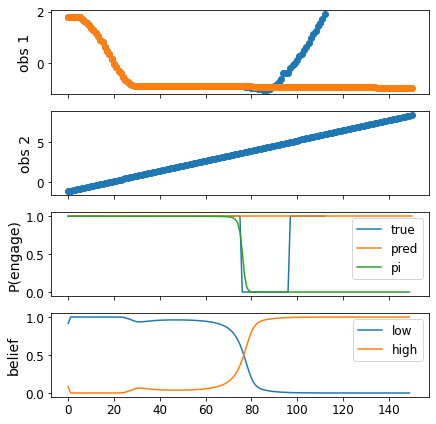

In [ ]:
fig, ax = plt.subplots(4, 1, figsize=(6, 6), sharex="col")
ax[0].plot(obs_test, "o", label="true")
ax[0].plot(obs_sim[:, 0], "o", label="pred")
ax[0].set_ylabel("obs 1")

ax[1].plot(obs_sim[:, 1], "o", label="true")
ax[1].set_ylabel("obs 2")

ax[2].plot(act_test, label="true")
ax[2].plot(act_sim, label="pred")
ax[2].plot(pi[:, 0, 1], label="pi")
ax[2].legend()
ax[2].set_ylabel("P(engage)")

ax[3].plot(b[:, 0, 0], label="low")
ax[3].plot(b[:, 0, 1], label="high")
ax[3].legend()
ax[3].set_ylabel("belief")

plt.tight_layout()
plt.show()